In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import requests
from google.colab import files
from plotnine import *
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler #Z-score variables
from sklearn.metrics import r2_score, accuracy_score, confusion_matrix, f1_score, recall_score, precision_score, roc_auc_score


from sklearn.model_selection import KFold 

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


#Upload Original_Subscriber_Information.csv and Original_App_activity.csv

In [2]:
def cleanDF(df):
    all_cols = ['ID', 'Language', 'Subscription Type', 'Subscription Event Type',
                'Purchase Store', 'Purchase Amount', 'Currency',
                'Subscription Start Date', 'Subscription Expiration', 'Demo User',
                'Free Trial User', 'Free Trial Start Date', 'Free Trial Expiration',
                'Auto Renew', 'Country', 'User Type', 'Lead Platform',
                'Email Subscriber', 'Push Notifications', 'Send Count', 'Open Count',
                'Click Count', 'Unique Open Count', 'Unique Click Count',
                'App Session Platform', 'App Activity Type', 'App Session Date']

    category_cols = ['Language', 'Subscription Type', 'Subscription Event Type', 'Purchase Store',
                    'Currency', 'Country', 'User Type', 'Lead Platform',
                    'App Session Platform', 'App Activity Type']

    int_cols = ['ID', 'Send Count', 'Open Count', 'Click Count', 'Unique Open Count', 'Unique Click Count']

    date_cols = ['Subscription Start Date', 'Subscription Expiration',
                'App Session Date', 'Free Trial Start Date', 'Free Trial Expiration']

    bool_cols = ['Demo User', 'Free Trial User', 'Auto Renew',
                'Email Subscriber', 'Push Notifications']

    # Keep only columns that exist in df
    all_cols = [col for col in all_cols if col in df.columns]
    category_cols = [col for col in category_cols if col in df.columns]
    int_cols = [col for col in int_cols if col in df.columns]
    date_cols = [col for col in date_cols if col in df.columns]
    bool_cols = [col for col in bool_cols if col in df.columns]

    # if 'Auto Renew' is in df.columns
    if 'Auto Renew' in df.columns:
        # convert to True/False
        df['Auto Renew'] = df['Auto Renew'].replace({'On': True, 'Off': False})

    # convert na to 0 in int_cols
    df[int_cols] = df[int_cols].fillna(0)

    df[category_cols] = df[category_cols].astype('category')
    df[int_cols] = df[int_cols].astype('int64')
    df[date_cols] = df[date_cols].astype('datetime64[ns]')
    df[bool_cols] = df[bool_cols].astype('bool')

    return df

def transform_value(value):
    if pd.isnull(value):
        return value
    value_str = str(int(value))
    if value_str.endswith('0000'):
        value_int = int(value / 10000)
        return float(value_int / 100)
    else:
        return value

#fetch exchange rates
def fetch_exchange_rates(api_key, currencies):
    currency_list = ','.join(currencies)
    url = f'https://openexchangerates.org/api/latest.json?app_id={api_key}&symbols={currency_list}'
    response = requests.get(url)
    
    if response.status_code == 200:
        return response.json()['rates']
    else:
        raise ValueError(f"Failed to fetch exchange rates. Status code: {response.status_code}")

#convert to USD
def convert_to_usd(amount, currency, exchange_rates):
    if currency in exchange_rates:
        return amount / exchange_rates[currency]
    else:
        return amount

def convert_currencies_to_usd(data_frame, amount_column, currency_column, exchange_rates):
    data_frame[amount_column] = data_frame.apply(lambda row: convert_to_usd(row[amount_column], row[currency_column], exchange_rates), axis=1)
    return data_frame

In [3]:
#CREATE MERGED DF
# clean subscriberDF 
subscriberDF = pd.read_csv('Original_Subscriber_Information.csv')
subscriberDF['Purchase Amount'] = subscriberDF['Purchase Amount'].apply(transform_value)

currencies = [
    'AED', 'AUD', 'BGN', 'BRL', 'CAD', 'CHF', 'CLP', 'COP', 'CRC', 'CZK',
    'DKK', 'EGP', 'EUR', 'GBP', 'GHS', 'HKD', 'HUF', 'IDR', 'ILS', 'INR',
    'JPY', 'KRW', 'KZT', 'LBP', 'MXN', 'MYR', 'NOK', 'NZD', 'PEN', 'PHP',
    'PLN', 'QAR', 'RON', 'RSD', 'RUB', 'SAR', 'SEK', 'SGD', 'THB', 'TRY',
    'UAH', 'VND', 'ZAR'
]

api_key = '418dd91a76a743c7bee44a1feb77fe51'
exchange_rates = fetch_exchange_rates(api_key, currencies)

subscriberDF = convert_currencies_to_usd(subscriberDF, 'Purchase Amount', 'Currency', exchange_rates)


# clean appDF
appDF = pd.read_csv('Original_App_activity.csv')
appDF.dropna()
appDF = appDF.dropna(subset=['App Activity Type', 'App Session Platform', 'App Session Date'])
appDF.to_csv('app_nonull.csv', index=False)

# Use currencies to determine the country of the subscriber
currency_to_country = {
    'AED': 'United Arab Emirates',
    'AUD': 'Australia',
    'BGN': 'Bulgaria',
    'BRL': 'Brazil',
    'CAD': 'Canada',
    'CHF': 'Switzerland',
    'CLP': 'Chile',
    'COP': 'Colombia',
    'CRC': 'Costa Rica',
    'CZK': 'Czech Republic',
    'DKK': 'Denmark',
    'EGP': 'Egypt',
    'EUR': 'European Union',
    'GBP': 'United Kingdom',
    'GHS': 'Ghana',
    'HKD': 'Hong Kong',
    'HUF': 'Hungary',
    'IDR': 'Indonesia',
    'ILS': 'Israel',
    'INR': 'India',
    'JPY': 'Japan',
    'KRW': 'South Korea',
    'KZT': 'Kazakhstan',
    'LBP': 'Lebanon',
    'MXN': 'Mexico',
    'MYR': 'Malaysia',
    'NOK': 'Norway',
    'NZD': 'New Zealand',
    'PEN': 'Peru',
    'PHP': 'Philippines',
    'PLN': 'Poland',
    'QAR': 'Qatar',
    'RON': 'Romania',
    'RSD': 'Serbia',
    'RUB': 'Russia',
    'SAR': 'Saudi Arabia',
    'SEK': 'Sweden',
    'SGD': 'Singapore',
    'THB': 'Thailand',
    'TRY': 'Turkey',
    'UAH': 'Ukraine',
    'USD': 'United States',
    'VND': 'Vietnam',
    'ZAR': 'South Africa'
}

#skip rows with na or nan in currency
subscriberDF['Country'] = subscriberDF['Currency'].apply(lambda currency: currency_to_country[currency] if currency in currency_to_country else None)
subscriberDF.to_csv('subscriberClean.csv', index=False)

merged_df = subscriberDF.merge(appDF, on='ID', how='left')

merged_df.to_csv("mergedClean.csv")


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
files.download('mergedClean.csv')
files.download('app_nonull.csv')
files.download('subscriberClean.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
mergedClean = pd.read_csv("mergedClean.csv")

In [6]:

mergedClean.count()


Unnamed: 0                 831799
ID                         831799
Language                   831798
Subscription Type          831798
Subscription Event Type    831798
Purchase Store             831798
Purchase Amount            453311
Currency                   453618
Subscription Start Date    831798
Subscription Expiration    831798
Demo User                  831798
Free Trial User            831798
Free Trial Start Date      183195
Free Trial Expiration      183195
Auto Renew                 831753
Country                    453618
User Type                  831798
Lead Platform              831798
Email Subscriber           831798
Push Notifications         831798
Send Count                 604450
Open Count                 604450
Click Count                604450
Unique Open Count          604450
Unique Click Count         604450
App Session Platform       797131
App Activity Type          797131
App Session Date           797131
dtype: int64

In [8]:
mergedClean.corr().style.background_gradient(cmap = "Blues")


,Unnamed: 0,Purchase Amount,Send Count,Open Count,Click Count,Unique Open Count,Unique Click Count
Unnamed: 0,1.000000,0.041575,0.029202,-0.020359,-0.021562,0.018824,0.006021
Purchase Amount,0.041575,1.000000,0.058094,0.056960,0.019968,0.134380,0.214554
Send Count,0.029202,0.058094,1.000000,0.869493,0.789611,0.427947,0.321824
Open Count,-0.020359,0.056960,0.869493,1.000000,0.942187,0.356560,0.279804
Click Count,-0.021562,0.019968,0.789611,0.942187,1.000000,0.060047,0.186433
Unique Open Count,0.018824,0.134380,0.427947,0.356560,0.060047,1.000000,0.415830
Unique Click Count,0.006021,0.214554,0.321824,0.279804,0.186433,0.415830,1.000000


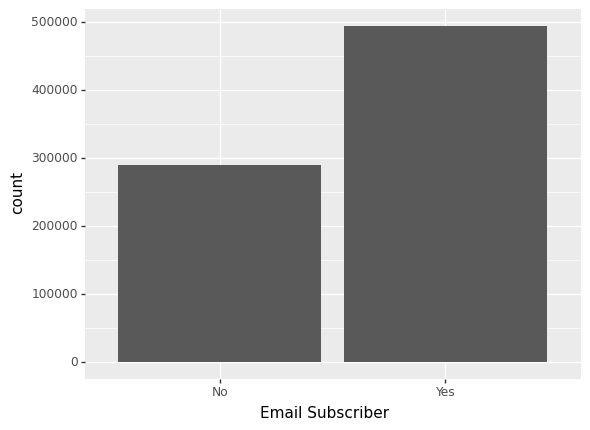

<ggplot: (8790103102398)>

In [ ]:
ggplot(mergedClean, aes(x = "Email Subscriber", fill = "Unique Click Count")) + geom_bar()


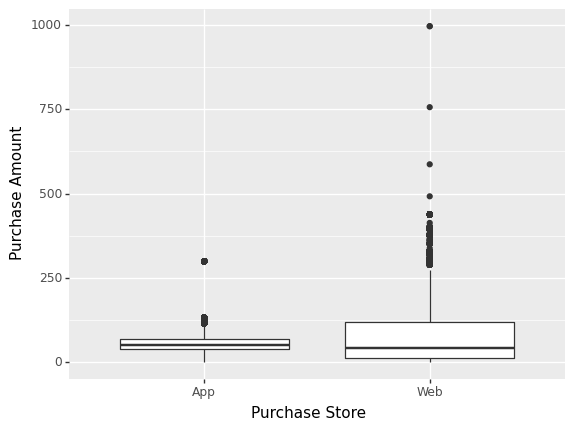

<ggplot: (8778955831462)>

In [ ]:
(ggplot(mergedClean, aes(x = "Purchase Store", y = "Purchase Amount")) + geom_boxplot())

In [ ]:
print(mergedClean.isnull().sum())

Unnamed: 0                      0
ID                              0
Language                        0
Subscription Type               0
Subscription Event Type         0
Purchase Store                  0
Purchase Amount            361445
Currency                   361138
Subscription Start Date         0
Subscription Expiration         0
Demo User                       0
Free Trial User                 0
Free Trial Start Date      608407
Free Trial Expiration      608407
Auto Renew                     45
Country                    361138
User Type                       0
Lead Platform                   0
Email Subscriber                0
Push Notifications              0
Send Count                 213945
Open Count                 213945
Click Count                213945
Unique Open Count          213945
Unique Click Count         213945
App Session Platform        16383
App Activity Type           16383
App Session Date            16383
dtype: int64


In [10]:
mergedClean.replace(('Yes', 'No'), (1,0), inplace=True)
mergedClean.replace(('On', 'Off'), (1,0), inplace=True)
mergedClean.replace(('Consumer', 'Other'), (1,0), inplace=True)
mergedClean.replace(('Lifetime', 'Limited'), (1,0), inplace=True)
mergedClean.replace(('INITIAL_PURCHASE', 'RENEWAL'), (1,0), inplace=True)
mergedClean.replace(('Web', 'App'), (1,0), inplace=True)

#mergedClean = mergedClean.dropna()

In [13]:
preds = ['Purchase Amount', 'Purchase Store', 'Subscription Type', 'Subscription Event Type', 'Demo User', 'Free Trial User', 'Unique Click Count','User Type', 'Email Subscriber', 'Push Notifications', 'Send Count', 'Open Count', 'Click Count']
cont = ['Purchase Amount', 'Send Count', 'Open Count', 'Click Count']


x = mergedClean[preds]
y = mergedClean['Auto Renew']



kf = KFold(n_splits = 10)


lr = LogisticRegression()


acc_train = []
acc_test = []

roc_train = []
roc_test = []


for train_indices, test_indices in kf.split(x):
  x_train = x.iloc[train_indices]
  x_test = x.iloc[test_indices]
  y_train = y.iloc[train_indices]
  y_test = y.iloc[test_indices]

#perform z-scoring
z = StandardScaler()
x_train[cont] = z.fit_transform(x_train[cont])
x_test[cont] = z.transform(x_test[cont])

#fit the model
lr.fit(x_train, y_train)

#store the accuracies
acc_train.append(accuracy_score(y_train, lr.predict(x_train)))
acc_test.append(accuracy_score(y_test, lr.predict(x_test)))

roc_train.append(roc_auc_score(y_train, lr.predict_proba(x_train)[:,1], multi_class='ovo'))
roc_test.append(roc_auc_score(y_test, lr.predict_proba(x_test)[:,1], multi_class='ovo'))

#print ROC and accuracies
print("Train model accuracies:",np.round(acc_train, 2))
print("Train model mean accuracy:",np.mean(acc_train))

print("Test model accuracies:",np.round(acc_test, 2))
print("Test model mean accuracy:",np.mean(acc_test))

'/n'

print("Train model ROCs:",np.round(roc_train, 2))
print("Train model mean ROC:",np.mean(roc_train))

print("Test model ROCs:",np.round(roc_test, 2))
print("Test model mean ROC:",np.mean(roc_test))

Train model accuracies: [0.74]
Train model mean accuracy: 0.7436135220900411
Test model accuracies: [0.67]
Test model mean accuracy: 0.6714919144496609
Train model ROCs: [0.83]
Train model mean ROC: 0.8345639932916606
Test model ROCs: [0.83]
Test model mean ROC: 0.8314361813369514


In [15]:
lrnew = LogisticRegression()


z = StandardScaler()
x[cont] = z.fit_transform(x[cont])

lrnew.fit(x, y)

coef = pd.DataFrame({'Coefficients': lrnew.coef_[0], 'Name': preds})
coef

,Coefficients,Name
0,0.167943,Purchase Amount
1,-3.400391,Purchase Store
2,-7.633114,Subscription Type
3,-0.964308,Subscription Event Type
4,-0.169887,Demo User
5,2.252051,Free Trial User
6,0.083508,Unique Click Count
7,-3.468828,User Type
8,0.333355,Email Subscriber
9,2.252051,Push Notifications


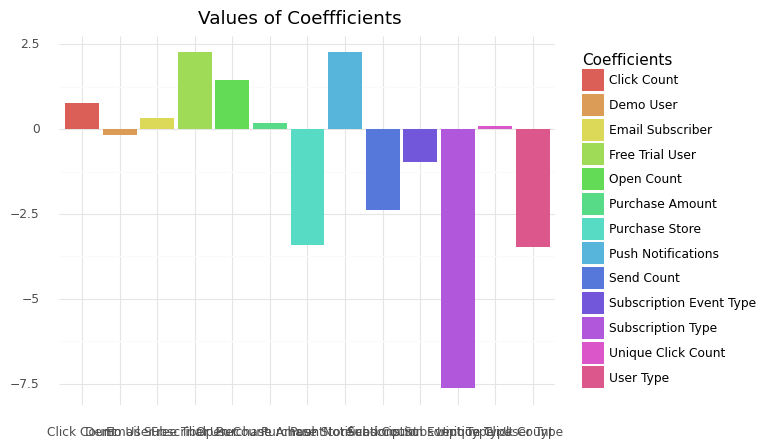

<ggplot: (8755045884739)>

In [17]:
#coefficients = pd.DataFrame({"Coeff": lrnew.coef_,
             #                "Name" : preds})

(ggplot(coef, aes(x = "Name", y = "Coefficients", fill = "Name")) +
 ggtitle("Values of Coeffficients") +
 labs(x = "", y = "", fill = "Coefficients") +
 theme_minimal() +
 geom_bar(stat = "identity"))

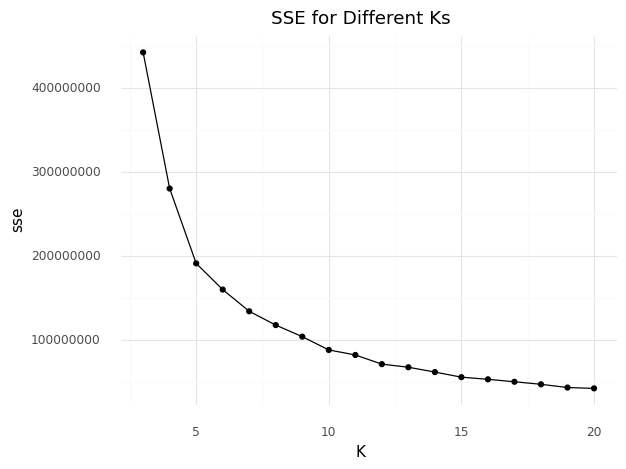

<ggplot: (8778955906006)>

In [ ]:
#finding optimal value for K by using the elbow method
ks = [3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

sse = []
sil = []

for k in ks:
  km = KMeans(n_clusters = k)
  km.fit(mergedClean[preds])

  sse.append(km.inertia_)
  sil.append(silhouette_score(mergedClean[preds], km.predict(mergedClean[preds])))

df = pd.DataFrame({"K": ks,
                   "sse": sse,
                   "silhouette": sil})

(ggplot(df, aes(x = "K", y = "sse")) + 
 geom_line() + geom_point() +
 theme_minimal() + 
 labs(title = "SSE for Different Ks"))